In [ ]:

import cv2
import numpy as np
from IPython.display import display, clear_output
from ultralytics import YOLO
import ipywidgets as widgets
import os
import matplotlib.pyplot as plt
from IPython.display import clear_output


In [ ]:

# Cell 3: Load YOLOv8 model
model = YOLO('yolov8m.pt')  # fast + lightweight


In [ ]:

# Get COCO class names
COCO_CLASSES = model.names

# Cell 4: User selects classes
class_selector = widgets.SelectMultiple(
    options=list(COCO_CLASSES.values()),
    value=['person', 'cat', 'dog'],
    description='Select classes to detect:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)
display(class_selector)


In [ ]:

# Cell 5: File selector widget
video_path_widget = widgets.Text(
    value='dog_cat_child_2.mp4',
    description='Video File Path:',
    layout=widgets.Layout(width='75%')
)
display(video_path_widget)


In [ ]:

# Cell 6: Helper function to compute relative position
def get_relative_position(box_center, frame_center):
    x_rel = 2 * (box_center[0] - frame_center[0]) / frame_center[0]
    y_rel = 2 * (box_center[1] - frame_center[1]) / frame_center[1]
    return round(x_rel, 2), round(y_rel, 2)


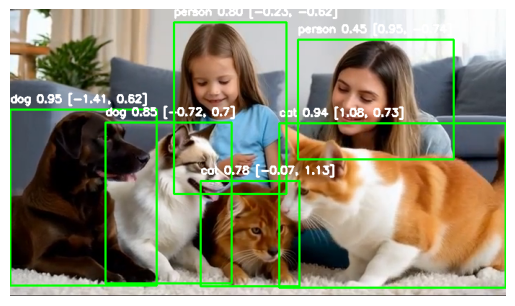

✅ End of video stream.
✅ Video processing complete.


In [15]:
# Cell 7: Load video file and process
video_path = video_path_widget.value

if not os.path.exists(video_path):
    print(f"❌ File not found: {video_path}")
else:
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Unable to open video.")
    else:
        ret, frame = cap.read()
        if not ret:
            print("❌ Unable to read video.")
        else:
            h, w = frame.shape[:2]
            frame_center = np.array([w / 2, h / 2])
            print("🎥 Processing video...")

            try:
                frame_count = 0
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        print("✅ End of video stream.")
                        break

                    results = model(frame)[0]
                    annotated_frame = frame.copy()
                    output_data = []

                    for i, det in enumerate(results.boxes):
                        cls_id = int(det.cls[0])
                        cls_name = COCO_CLASSES[cls_id]

                        if cls_name not in class_selector.value:
                            continue

                        conf = float(det.conf[0])
                        x1, y1, x2, y2 = map(int, det.xyxy[0])
                        box_center = np.array([(x1 + x2) / 2, (y1 + y2) / 2])
                        rel_x, rel_y = get_relative_position(box_center, frame_center)

                        label = f"{cls_name} {conf:.2f} [{rel_x}, {rel_y}]"
                        cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(annotated_frame, label, (x1, y1 - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

                        output_data.append({
                            "frame": frame_count,
                            "id": i,
                            "class": cls_name,
                            "confidence": round(conf, 2),
                            "rel_position": {"x": rel_x, "y": rel_y}
                        })

                    for obj in output_data:
                        print(obj)

                    # Convert BGR to RGB for displaying with matplotlib
                    annotated_frame_rgb = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)

                    # Display the frame using matplotlib
                    clear_output(wait=True)  # Clear previous output
                    plt.imshow(annotated_frame_rgb)
                    plt.axis('off')  # Hide axis
                    plt.show()

                    frame_count += 1

            finally:
                cap.release()  # Release the video capture
                print("✅ Video processing complete.")